## Model Trainer using the FastAI library
Tuning the original model, trying to build in heatmaps.

### Current Tuning List:
1. Recheck learning rate slices - weird to use
2. Iterative Resizing - seems to just increase reliability of reaching high acc
3. Regularization param loosening -

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64 # dependent on GPU in use

### Obtaining the Dataset
Uncomment and run this section after first downloading the repo to get the data.

In [4]:
from pathlib import Path

In [5]:
path = Path('./data')
path

PosixPath('data')

In [6]:
# ! kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p "{path}"
# ! unzip "{path}/skin-cancer-malignant-vs-benign.zip" -d "{path}"

Now have the data...

## Data Visualization

In [7]:
path_train = path/'train'
path_test = path/'test'
path_train

PosixPath('data/train')

The data is labeled by folder. That sounds like a standard case for Image Data bunch

In [8]:
(path/'train').ls()

[PosixPath('data/train/benign'), PosixPath('data/train/malignant')]

### Transform Experiments:
1. Max_rotate = 90&deg; doesn't work well, doesn't encounter rotated images I guess.  Also not adding any robustness

In [9]:
tfms = get_transforms(flip_vert=True, max_warp=0.1)

In [4]:
get_transforms?

Should we use the test set for validation?

### Data setup at 128 for Resizing

In [10]:
data = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=112, bs=bs).normalize(imagenet_stats)

Need to set up a validation set using the Datablock api

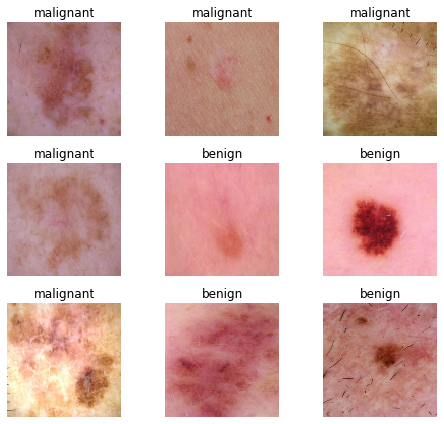

In [11]:
data.show_batch(rows=3,figsize=(7,6))

### Resnet 34 - 2 Stage Iterative Resizing

In [76]:
learn = cnn_learner(data, models.resnet34, bn_final=False, metrics=error_rate)

In [77]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### Attempt using Resnet 34

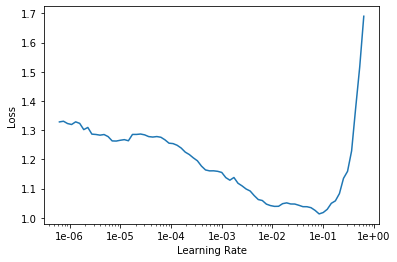

In [78]:
learn.recorder.plot()

In [79]:
learn.fit_one_cycle(8, 1e-1/4, wd=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.778296,0.613422,0.242792,00:04
1,0.603232,0.637327,0.248862,00:04
2,0.534898,0.567534,0.197269,00:04
3,0.450810,0.347132,0.150228,00:04
4,0.376536,0.289896,0.139605,00:04
5,0.321395,0.272644,0.130501,00:04
6,0.285485,0.256163,0.118361,00:04
7,0.255746,0.252364,0.115326,00:04


- what matters is getting up real close with the learning rate.
- sze 112 only seems to get to 87 percent accuracy

In [ ]:
#learn.save('stage-1-128-rn34-91')

### Model Fine-tuning

In [ ]:
learn.load('stage-1-128-rn34-91')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6, 1e-6)

Can't really push the batchnorm layer any farther in stage 2 than stage 1

Current best stage 2 error is 0.061457. Really variable

In [ ]:
#learn.save('stage-2-128-rn34-90')

### Upsize to 224
Reset data, 224

In [ ]:
learn.load('stage-2-128-rn34-90')

In [ ]:
data = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=224, bs=bs).normalize(imagenet_stats)
learn.data = data

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-2/4
learn.fit_one_cycle(6, slice(lr))

In [ ]:
#learn.save('stage-1-224-rn34-93')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 1e-5)

In [ ]:
#learn.save('stage-2-224-rn34-94')

## Resnet-50 Attempt, Iterative Resizing
Just repeating the process using the resnet 50 model. 

In [93]:
torch.cuda.empty_cache()

In [94]:
#learn.destroy()

In [95]:
data50 = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=112, bs=bs//2).normalize(imagenet_stats)

In [108]:
learn50 = cnn_learner(data50, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


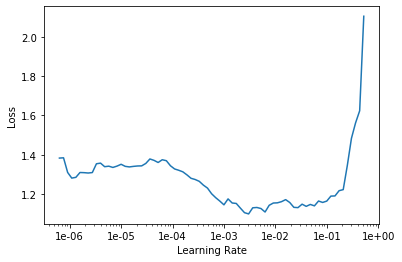

In [106]:
learn50.lr_find()
learn50.recorder.plot()

In [109]:
learn50.fit_one_cycle(8, 1e-1/8, wd=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.744286,0.478289,0.153263,00:07
1,0.585835,0.603463,0.224583,00:07
2,0.452519,0.501602,0.177542,00:07
3,0.394621,0.306148,0.135053,00:07
4,0.353689,0.293772,0.125948,00:07
5,0.311811,0.245962,0.118361,00:07
6,0.287991,0.221233,0.100152,00:07
7,0.237021,0.216217,0.088012,00:07


Resnet 50 112 gets to 89

In [112]:
#learn50.save('stage-1-112-rn50-92')

In [151]:
learn50.load('stage-1-112-rn50-92')

Learner(data=ImageDataBunch;

Train: LabelList (2638 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
benign,benign,benign,benign,benign
Path: data;

Valid: LabelList (659 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
benign,malignant,malignant,malignant,benign
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [152]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


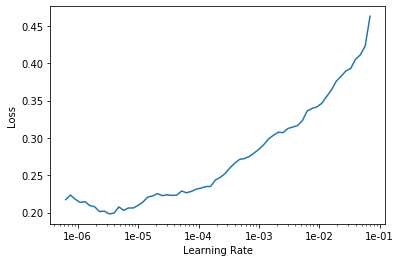

In [153]:
learn50.lr_find()
learn50.recorder.plot()

In [154]:
learn50.fit_one_cycle(4, 1e-5/2, wd=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.225068,0.208738,0.086495,00:09
1,0.221457,0.208906,0.088012,00:09
2,0.204798,0.204891,0.086495,00:09
3,0.210723,0.204431,0.086495,00:09


In [155]:
#learn50.save('stage-2-112-rn50-92')

## Sizing up to 224, Resnet 50

In [209]:
learn50.load('stage-2-112-rn50-92')

Learner(data=ImageDataBunch;

Train: LabelList (2638 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
benign,benign,benign,benign,benign
Path: data;

Valid: LabelList (659 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,malignant,malignant,benign,malignant
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [210]:
data50 = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=224, bs=bs//2).normalize(imagenet_stats)

In [211]:
learn50.data = data50

In [212]:
learn50.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


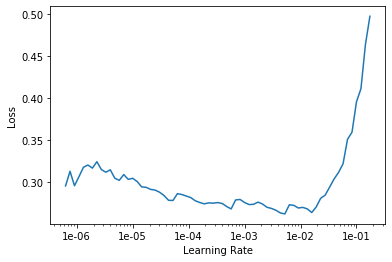

In [213]:
learn50.lr_find()
learn50.recorder.plot()

In [214]:
lr = 1e-2/8
learn50.fit_one_cycle(7, lr, wd=0.2)

epoch,train_loss,valid_loss,error_rate,time
0,0.267141,0.233166,0.115326,00:21
1,0.265044,0.226417,0.115326,00:21
2,0.240163,0.212012,0.109256,00:21
3,0.228671,0.209138,0.100152,00:21
4,0.213068,0.208401,0.092564,00:21
5,0.203208,0.185042,0.078907,00:22
6,0.188487,0.195921,0.088012,00:22


In [215]:
#learn50.save('stage-1-224-rn50-92')

In [235]:
torch.cuda.empty_cache()

In [231]:
learn50.load('stage-1-224-rn50-92')

Learner(data=ImageDataBunch;

Train: LabelList (2638 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
benign,benign,benign,benign,benign
Path: data;

Valid: LabelList (659 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
benign,benign,benign,malignant,benign
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [232]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


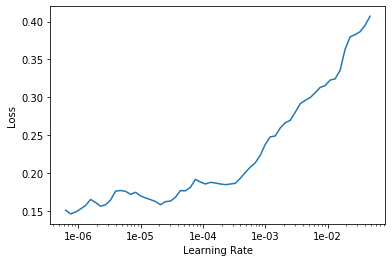

In [233]:
learn50.lr_find()
learn50.recorder.plot()

In [234]:
learn50.fit_one_cycle(6, 1e-5/2, wd=0.3)

epoch,train_loss,valid_loss,error_rate,time
0,0.173462,0.190131,0.084977,00:25
1,0.188448,0.185777,0.083460,00:25
2,0.176484,0.182340,0.081942,00:25
3,0.170011,0.187705,0.084977,00:25
4,0.167681,0.180820,0.081942,00:25
5,0.163743,0.183488,0.080425,00:25


In [ ]:
#learn50.save('stage-2-224-rn50-94')

### First results interpretation:
Turns out I can't actually read Cancer screening images, so I'm just going to go for the full training routine, and maybe we'll get someone to look at this later.

In [ ]:
learn.load('stage-2-224-rn34-94')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn50)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))